In [10]:
import tensorflow as tf
import numpy as np

np.random.seed(0)
tf.random.set_seed(0)

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
try:
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        print("Successfully set visible devices to GPU 0")
except RuntimeError as e:
    print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU
Successfully set visible devices to GPU 0


Kiểm tra và cấu hình GPU

> Add blockquote



Nhập thư viện cần thiết

> Nhập các thư viện Python và Keras để xử lý ảnh, xây dựng mô hình CNN, và tăng cường dữ liệu



In [11]:
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Activation
from keras.optimizers import Adam
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pickle
import pandas as pd
import random
import cv2

In [12]:
# Đọc dữ liệu từ 3 file train,validd,test
data = pd.read_csv("/content/drive/MyDrive/Data/signnames.csv")
with open('/content/drive/MyDrive/Data/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('/content/drive/MyDrive/Data/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('/content/drive/MyDrive/Data/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train_RGB, y_train = train_data['features'], train_data['labels']
X_val_RGB, y_val = val_data['features'], val_data['labels']
X_test_RGB, y_test = test_data['features'], test_data['labels']

print("X_train_RGB shape:", X_train_RGB.shape)
print("X_val_RGB shape:", X_val_RGB.shape)
print("X_test_RGB shape:", X_test_RGB.shape)

X_train_RGB shape: (34799, 32, 32, 3)
X_val_RGB shape: (4410, 32, 32, 3)
X_test_RGB shape: (12630, 32, 32, 3)


Tải và kiểm tra dữ liệu

> Đọc dữ liệu huấn luyện, kiểm tra, và xác thực từ file pickle và CSV, hiển thị kích thước các tập dữ liệu.



Tiền xử lý và tăng cường dữ liệu

In [13]:
def preprocessing(img):
    img_copy = img.copy()
    img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_gray)
    img_normalized = img_clahe / 255.0
    return img_normalized.astype(np.float32)

X_train = np.array(list(map(preprocessing, X_train_RGB)))
X_val = np.array(list(map(preprocessing, X_val_RGB)))
X_test = np.array(list(map(preprocessing, X_test_RGB)))

# Reshape data
X_train = X_train.reshape(X_train_RGB.shape[0], 32, 32, 1)
X_val = X_val.reshape(X_val_RGB.shape[0], 32, 32, 1)
X_test = X_test.reshape(X_test_RGB.shape[0], 32, 32, 1)

print("X_train shape after reshape:", X_train.shape)

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10
)
datagen.fit(X_train)

num_classes = 43
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

X_train shape after reshape: (34799, 32, 32, 1)


Xây dựng mô hình CNN cải tiến

> Định nghĩa mô hình CNN với các lớp BatchNormalization, Dropout, và số filter tăng để cải thiện hiệu suất.



In [14]:
def cnn_model_improved():
    input_tensor = Input(shape=(32, 32, 1))
    x = Conv2D(60, (5, 5), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(60, (5, 5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(120, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(120, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Flatten()(x)
    x = Dense(500)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(200)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=['accuracy'])
    return model

model = cnn_model_improved()
print("Model Summary:")
model.summary()

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 60)     │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 60)     │           240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 120)    │        64,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 120)    │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 16, 16, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 120)    │       129,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 120)    │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 120)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 120)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 500)            │     3,840,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 500)            │         2,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,239,843 (16.17 MB)

 Trainable params: 4,237,723 (16.17 MB)

 Non-trainable params: 2,120 (8.28 KB)

Huấn luyện mô hình

In [15]:
# Define Callbacks
model_checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/TrafficSign_Improved_Best_Model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Train model
print("\n--- Training a_improved_model ---")
batch_size = 64
epochs = 50
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=max(1, len(X_train) // batch_size),
    epochs=epochs,
    validation_data=(X_val, y_val),
    shuffle=True,
    callbacks=[model_checkpoint, early_stopping, reduce_lr]
)


--- Training a_improved_model ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


542/543 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3489 - loss: 2.5238
Epoch 1: val_accuracy improved from -inf to 0.76054, saving model to /content/drive/MyDrive/TrafficSign_Improved_Best_Model.keras
543/543 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.3495 - loss: 2.5207 - val_accuracy: 0.7605 - val_loss: 0.7444 - learning_rate: 0.0010
Epoch 2/50
  1/543 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.6719 - loss: 0.8456

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.76054 to 0.77120, saving model to /content/drive/MyDrive/TrafficSign_Improved_Best_Model.keras
543/543 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6719 - loss: 0.8456 - val_accuracy: 0.7712 - val_loss: 0.7319 - learning_rate: 0.0010
Epoch 3/50
543/543 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8077 - loss: 0.6310
Epoch 3: val_accuracy improved from 0.77120 to 0.92426, saving model to /content/drive/MyDrive/TrafficSign_Improved_Best_Model.keras
543/543 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - accuracy: 0.8077 - loss: 0.6309 - val_accuracy: 0.9243 - val_loss: 0.2144 - learning_rate: 0.0010
Epoch 4/50
  1/543 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.9062 - loss: 0.3518
Epoch 4: val_accuracy improved from 0.92426 to 0.93537, saving model to /content/drive/MyDrive/TrafficSign_Improved_Best_Model.keras
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - loss: 0.3518 - val_accuracy: 0.9354 - val_loss: 0.1920 - learning_rate: 0.0010


Đánh giá mô hình qua biểu đồ và lưu mô hình sau khi train


Loading the best saved model for evaluation...

--- Evaluating Model ---
Test Loss: 0.04874192550778389
Test Accuracy: 0.9859066009521484


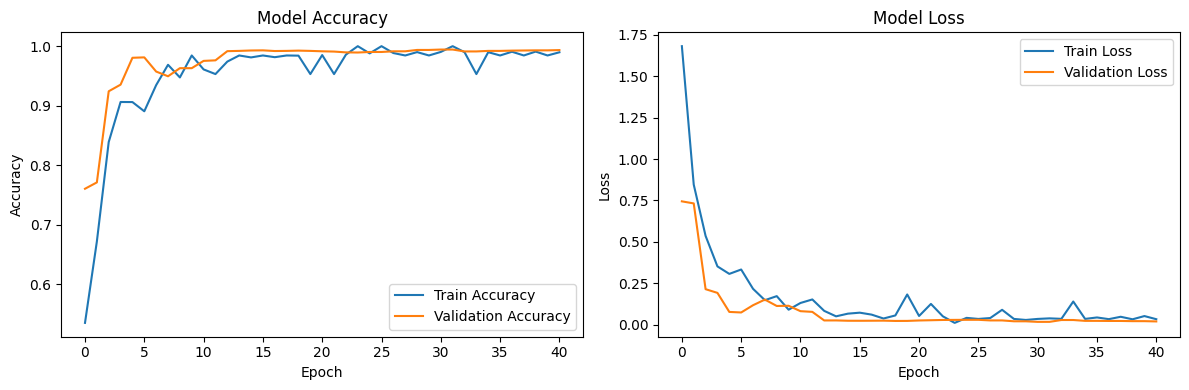

In [16]:
print("\nLoading the best saved model for evaluation...")
model.load_weights('/content/drive/MyDrive/Data/TrafficSign_Improved_Best_Model.keras')

# Evaluate model
print("\n--- Evaluating Model ---")
score = model.evaluate(X_test, y_test_cat, verbose=0)
print('Test Loss:', score[0])
print('Test Accuracy:', score[1])



# Visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()


--- Visualizing Predictions ---
395/395 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


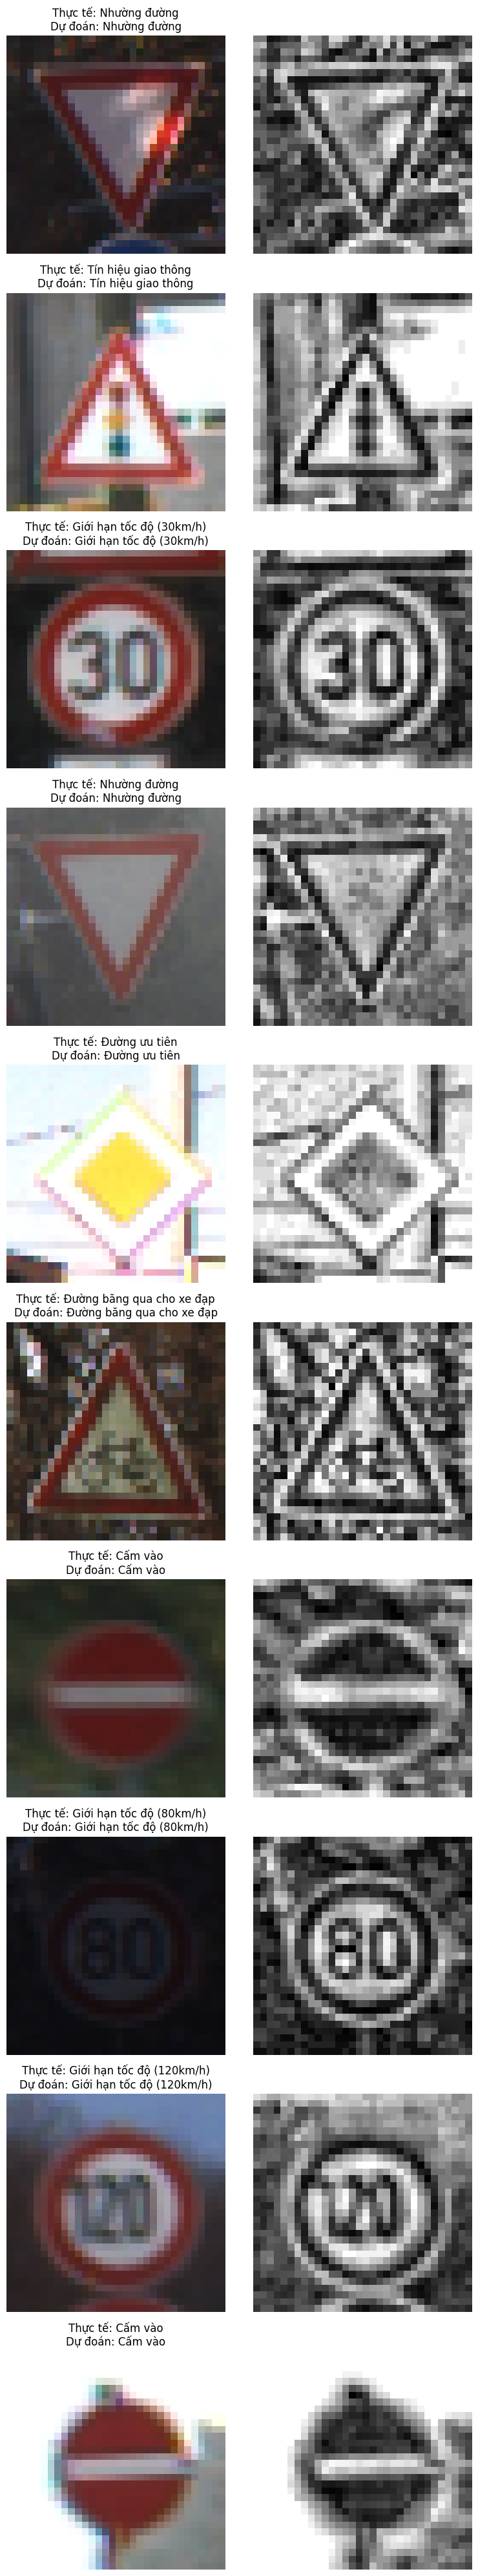

In [17]:
# Dictionary to map English sign names to Vietnamese
sign_name_vn = {
    "Speed limit (20km/h)": "Giới hạn tốc độ (20km/h)",
    "Speed limit (30km/h)": "Giới hạn tốc độ (30km/h)",
    "Speed limit (50km/h)": "Giới hạn tốc độ (50km/h)",
    "Speed limit (60km/h)": "Giới hạn tốc độ (60km/h)",
    "Speed limit (70km/h)": "Giới hạn tốc độ (70km/h)",
    "Speed limit (80km/h)": "Giới hạn tốc độ (80km/h)",
    "End of speed limit (80km/h)": "Kết thúc giới hạn tốc độ (80km/h)",
    "Speed limit (100km/h)": "Giới hạn tốc độ (100km/h)",
    "Speed limit (120km/h)": "Giới hạn tốc độ (120km/h)",
    "No passing": "Cấm vượt",
    "No passing for vechiles over 3.5 metric tons": "Cấm vượt cho xe trên 3.5 tấn",
    "Right-of-way at the next intersection": "Ưu tiên tại ngã tư tiếp theo",
    "Priority road": "Đường ưu tiên",
    "Yield": "Nhường đường",
    "Stop": "Dừng lại",
    "No vechiles": "Cấm tất cả phương tiện",
    "Vechiles over 3.5 metric tons prohibited": "Cấm xe trên 3.5 tấn",
    "No entry": "Cấm vào",
    "General caution": "Cảnh báo chung",
    "Dangerous curve to the left": "Khúc cua nguy hiểm bên trái",
    "Dangerous curve to the right": "Khúc cua nguy hiểm bên phải",
    "Double curve": "Cua đôi",
    "Bumpy road": "Đường gồ ghề",
    "Slippery road": "Đường trơn trượt",
    "Road narrows on the right": "Đường hẹp bên phải",
    "Road work": "Công trường",
    "Traffic signals": "Tín hiệu giao thông",
    "Pedestrians": "Người đi bộ",
    "Children crossing": "Đường băng qua cho trẻ em",
    "Bicycles crossing": "Đường băng qua cho xe đạp",
    "Beware of ice/snow": "Cẩn thận băng/tuyết",
    "Wild animals crossing": "Đường băng qua cho động vật hoang dã",
    "End of all speed and passing limits": "Kết thúc mọi giới hạn tốc độ và vượt",
    "Turn right ahead": "Rẽ phải phía trước",
    "Turn left ahead": "Rẽ trái phía trước",
    "Ahead only": "Chỉ đi thẳng",
    "Go straight or right": "Đi thẳng hoặc rẽ phải",
    "Go straight or left": "Đi thẳng hoặc rẽ trái",
    "Keep right": "Giữ bên phải",
    "Keep left": "Giữ bên trái",
    "Roundabout mandatory": "Bắt buộc vòng xuyến",
    "End of no passing": "Kết thúc cấm vượt",
    "End of no passing by vechiles over 3.5 metric tons": "Kết thúc cấm vượt cho xe trên 3.5 tấn"
}

# Visualize predictions
print("\n--- Visualizing Predictions ---")
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
correct_indices = np.where(y_pred_labels == y_test)[0]
num_images_to_plot = 10
selected_indices = random.sample(list(correct_indices), num_images_to_plot)
fig, axes = plt.subplots(num_images_to_plot, 2, figsize=(8, 4 * num_images_to_plot))
for i, index in enumerate(selected_indices):
    axes[i, 0].imshow(X_test_RGB[index])
    true_vi = sign_name_vn.get(data['SignName'][y_test[index]], data['SignName'][y_test[index]])
    pred_vi = sign_name_vn.get(data['SignName'][y_pred_labels[index]], data['SignName'][y_pred_labels[index]])
    axes[i, 0].set_title(f"Thực tế: {true_vi}\nDự đoán: {pred_vi}")
    axes[i, 0].axis('off')
    axes[i, 1].imshow(X_test[index].reshape(32, 32), cmap='gray')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()

Please upload an image for prediction:


Saving 80kmh.png to 80kmh.png
Predicted Sign: Speed limit (80km/h)
Confidence: 0.81


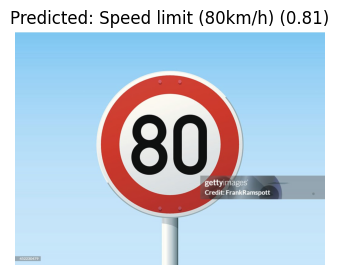

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from google.colab import files


sign_name_vn = {
    "Speed limit (20km/h)": "Giới hạn tốc độ (20km/h)",
    "Speed limit (30km/h)": "Giới hạn tốc độ (30km/h)",
    "Speed limit (50km/h)": "Giới hạn tốc độ (50km/h)",
    "Speed limit (60km/h)": "Giới hạn tốc độ (60km/h)",
    "Speed limit (70km/h)": "Giới hạn tốc độ (70km/h)",
    "Speed limit (80km/h)": "Giới hạn tốc độ (80km/h)",
    "End of speed limit (80km/h)": "Kết thúc giới hạn tốc độ (80km/h)",
    "Speed limit (100km/h)": "Giới hạn tốc độ (100km/h)",
    "Speed limit (120km/h)": "Giới hạn tốc độ (120km/h)",
    "No passing": "Cấm vượt",
    "No passing for vehicles over 3.5 metric tons": "Cấm vượt cho xe trên 3.5 tấn",
    "Right-of-way at the next intersection": "Ưu tiên tại ngã tư tiếp theo",
    "Priority road": "Đường ưu tiên",
    "Yield": "Nhường đường",
    "Stop": "Dừng lại",
    "No vehicles": "Cấm tất cả phương tiện",
    "Vehicles over 3.5 metric tons prohibited": "Cấm xe trên 3.5 tấn",
    "No entry": "Cấm vào",
    "General caution": "Cảnh báo chung",
    "Dangerous curve to the left": "Khúc cua nguy hiểm bên trái",
    "Dangerous curve to the right": "Khúc cua nguy hiểm bên phải",
    "Double curve": "Cua đôi",
    "Bumpy road": "Đường gồ ghề",
    "Slippery road": "Đường trơn trượt",
    "Road narrows on the right": "Đường hẹp bên phải",
    # TODO: Add mappings for all 43 classes from signnames.csv
}


# Load sign names
data = pd.read_csv("/content/drive/MyDrive/Data/signnames.csv")

# Load model
model = tf.keras.models.load_model('/content/drive/MyDrive/Data/TrafficSign_Improved_Best_Model.keras')

# Preprocessing function
def preprocessing(img):
    img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
    img = cv2.Laplacian(img, cv2.CV_64F)
    img = img / 255
    return img

# Function to predict traffic sign
def predict_traffic_sign(image_path):
    # Read and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        print("Error: Could not load image")
        return
    img_rgb = img.copy()  # Keep RGB for display
    img = cv2.resize(img, (32, 32))
    img = preprocessing(img)
    img = img.reshape(1, 32, 32, 1)

    # Predict
    prediction = model.predict(img, verbose=0)
    sign_class = np.argmax(prediction)
    confidence = np.max(prediction)

    # Get sign name
    sign_name = data['SignName'][sign_class]

    # Display results
    print(f"Predicted Sign: {sign_name}")
    print(f"Confidence: {confidence:.2f}")

    # Plot image
    plt.figure(figsize=(4, 4))
    plt.imshow(cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted: {sign_name} ({confidence:.2f})")
    plt.axis('off')
    # plt.savefig('/content/drive/MyDrive/prediction_output.png')
    # print("Prediction output saved to /content/drive/MyDrive/prediction_output.png")

# Upload image
print("Please upload an image for prediction:")
uploaded = files.upload()
if uploaded:
    image_path = list(uploaded.keys())[0]
    predict_traffic_sign(image_path)
else:
    print("No image uploaded")